# Testing experimentally bounding deviations from quantum theory in the landscape of generalized probabilistic theories

## Article

https://arxiv.org/abs/1710.05948

In [2]:
import sys
import numpy as np
import scipy as sp
from qiskit import *
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.providers.aer.extensions.snapshot_statevector import *
from math import pi, sqrt
import cvxopt
from cvxopt import matrix, solvers
import quadprog
import quantum_decomp as qdp
import matplotlib
from matplotlib import pyplot as plt
import gpt

## Experiment

### First Test

In the first test we prepare $n=100$ preparations and $m=100$ measurement settings. First we create a function that generates $n$ equally distanced points or states on the surface of the bloch sphere.

Next, we create circuits to simulate 100 preparations and 100 measurements. We will prepare 100 states of the form:

\\[\{|\psi_i>\}_{i=1}^{100}\\]

These states are uniformly distributed on the bloch sphere as implemented by the function above.

We will then implement the measurements with the following projective measurements:

\\[\{(|\psi_i><\psi_i|, \mathbb{I}-|\psi_i><\psi_i|)\}_{i=1}^{100}\\]

In [3]:
# get backend
backend = Aer.get_backend("aer_simulator")

# get list of n*m evenly distributed states on the bloch sphere
n = 100 # number of preparations
m = 100 # number of measurements
states_info = gpt.gen_eq_bloch_states(n)
F = np.zeros((n, m), dtype=float) # frequency matrix
var = np.zeros((n, m), dtype=float) # variance matrix

# loop through the preparations and measurements
for i in range(n):
    for j in range(m):
        qc = QuantumCircuit(1) # single qubit circuit
        state_i = states_info[0][i] #if j != 0 else states_info[0][0]
        state_j = states_info[0][j] if j != 0 else states_info[0][i]
        
        theta_j = states_info[1][j] if j != 0 else states_info[1][i]
        phi_j = states_info[2][j] if j != 0 else states_info[2][i]
        antipodal_state_j = [np.cos((theta_j+pi)/2), np.sin((theta_j+pi)/2)*np.exp(1j*phi_j)]
        
        a = state_j[0]
        b = antipodal_state_j[0]
        c = state_j[1]
        d = antipodal_state_j[1]
        A = np.array([[a, b], [c, d]], dtype=complex)
        #print(A)
        qc_gates = qdp.matrix_to_qiskit_circuit(A)
        #print(qc_gates)
        
        # construct circuits
        qc.initialize(state_i)
        qc.barrier()
        qc += qc_gates.inverse()
        #qc.snapshot_statevector('label')
        qc.measure_all()
        
        # Transpile for simulator
        backend = Aer.get_backend('aer_simulator')
        qc = transpile(qc, backend)

        # Run and get counts
        runs = 1000
        result = backend.run(qc, shots=runs).result()
        counts = result.get_counts(qc)
        #print(result.data()['snapshots'])
        #print(counts)
        
        # calculate frequency matrix and variance matrix
        zero_meas = counts.get('0') if not counts.get('0') is None else 0
        F[i][j] = zero_meas/runs
        avg = (runs - zero_meas)/runs
        var[i][j] = 1/(runs - 1)*((zero_meas*(avg**2))+((runs - zero_meas)*((1 - avg)**2)))

<ipython-input-3-4c1b274f3832>:46: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += qc_gates.inverse()
/Users/scubagibs/anaconda3/envs/QRESEARCH_ENV/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


[[1.    0.989 0.978 ... 0.022 0.012 0.   ]
 [1.    1.    0.992 ... 0.052 0.037 0.008]
 [1.    0.988 1.    ... 0.082 0.055 0.018]
 ...
 [1.    0.05  0.091 ... 1.    0.997 0.979]
 [1.    0.045 0.061 ... 0.998 1.    0.993]
 [1.    0.011 0.021 ... 0.983 0.991 1.   ]]


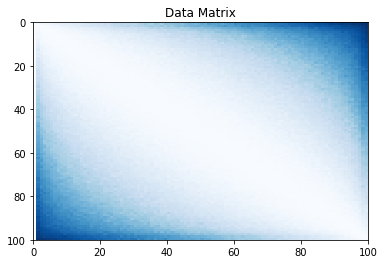

In [14]:
W = np.zeros((n*m, m*n), dtype=float) # W = 1/var
index = 0

for i in range(n):
    for j in range(m):
        W[index][index] = 1/(var[i][j]) if var[i][j] != 0 else 0
    index += 1

print(F)
#print(var)

plt.title("Data Matrix")
graph = plt.pcolormesh(F, cmap=matplotlib.pyplot.cm.Blues_r)
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

In [15]:
U, s, Vh = np.linalg.svd(F)
s = np.sort(s)[::-1]
#print(s)
S = np.diag(s)
S_0 = U
E_0 = S @ Vh

candidate_k = {2, 3, 4, 5}
for k in candidate_k:
    S_k = np.diag(s[0:k])
    Vh_k = Vh[0:k, 0:len(Vh[0])]
    U_k = U[0:len(U), 0:k]
    S_0 = U_k @ S_k
    E_0 = S_k @ Vh_k
    D_array = gpt.bfp(k, E_0, F, W, n, m)
    print(D_array[0] @ D_array[1])

     pcost       dcost       gap    pres   dres
 0: -1.0081e+03 -1.4638e+04  1e+04  2e-17  7e-16
 1: -1.0285e+03 -1.6927e+03  7e+02  2e-16  9e-16
 2: -1.0859e+03 -1.1623e+03  8e+01  2e-16  1e-16
 3: -1.0992e+03 -1.1062e+03  7e+00  2e-16  1e-16
 4: -1.0997e+03 -1.0999e+03  2e-01  2e-16  8e-17
 5: -1.0997e+03 -1.0997e+03  4e-03  2e-16  1e-16
 6: -1.0997e+03 -1.0997e+03  2e-04  2e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0978e+03 -1.5663e+04  1e+04  2e-17  2e-16
 1: -1.0991e+03 -1.3700e+03  3e+02  2e-16  2e-16
 2: -1.0996e+03 -1.1064e+03  7e+00  2e-16  7e-17
 3: -1.0997e+03 -1.0998e+03  1e-01  2e-16  5e-17
 4: -1.0997e+03 -1.0997e+03  4e-03  1e-16  5e-17
 5: -1.0997e+03 -1.0997e+03  5e-04  1e-16  6e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0968e+03 -1.6026e+04  1e+04  2e-17  2e-14
 1: -1.0988e+03 -1.4760e+03  4e+02  1e-16  1e-14
 2: -1.0995e+03 -1.1061e+03  7e+00  1e-16  4e-16
 3: -1.0997e+03 -1.0998e

ValueError: Rank(A) < p or Rank([P; A; G]) < n